In [40]:
using Base: @kwdef
using Parameters: @unpack
using Plots
using LinearAlgebra
using Distributions, Random
using SignalAnalysis

In [124]:
@kwdef mutable struct Input
    Fs::UInt32
    StopTime::Float32
    Width::Float32
    f_diff::UInt32
    f_exc::UInt32
    mid_point::Float32
    f_inh::UInt32
end

function add_cosine(T,A,t)
    # -1をかけて位相を逆にする
    return -1*(A/2*cos(pi*t/T))+A/2
end

function input_freq_update(variable::Input)
    @unpack Fs,StopTime,Width,f_diff,f_exc,mid_point,f_inh = variable
    dt = 1/Fs;
    inputs = []
    currents = []
    noises = []
    @time for i = 0:dt:StopTime
        starts = mid_point-(Width/2);
        ends = mid_point+(Width/2);
        output = f_exc + add_cosine(Width,f_diff,i-starts) * ((i >= starts) & (i <= ends)) + f_diff * (i > ends);
        append!(inputs,output)
        append!(currents,sin(2*pi*output*i))
        append!(noises,sin(2*pi*f_inh*i))
    end
    return inputs,currents,noises
end;

Ne = 70 # ニューロンの数
Ni = 280 # ニューロンの数

# Set Iteration point
dt = 1/1000
spikes = isone.(zeros(Ne+Ni))
spikes2 = isone.(zeros(Ne+Ni))

freq = Input(Fs=1000,StopTime=1.6,Width=0.1,f_diff=400,f_exc=100,mid_point=0.8,f_inh=100)
inputs, currents, noises = input_freq_update(freq);
println(length(inputs))

  0.000284 seconds (4.83 k allocations: 172.172 KiB)
1601


In [68]:
function pprocess_poisson(lambda)
    xs = [0.0];

    R = 0;
    
    x = 0.0;
    #while x <= lambda*dt
    while x <= 0.5
        x = x + - log(rand()) / lambda;
        push!(xs, round(x, digits=n));
    end
    
    return xs

end

pprocess_poisson (generic function with 1 method)

In [153]:
n=3
dt=1e-3
pprocess_poisson(100);

In [125]:
L=1601

function pprocess_inhomopoisson(lambda, noise)
    xs = [0.0];
    rs = zeros(L);
    R = 0;
    rs[1] = lambda[1];

    eta = - log(rand());
    for i = 2:L
        tau = i*dt - x[end];

        r = lambda[i]+noise[i];
        R = R + r*dt;

        if eta <= R
            push!(xs,round(i*dt, digits=3));

            R = 0.0;
            eta = - log(rand());
        end
        rs[i] = r;
    end

    return xs, rs
end

pprocess_inhomopoisson (generic function with 2 methods)

In [126]:
res, res2 = pprocess_inhomopoisson(inputs, noises)

spikes = zeros((1602, 1)) # スパイク 録変数

for r in res
    ind = round(r*1000, digits=3)
    ind = convert(Int64, ind);
    spikes[ind+1, 1] = 1
end

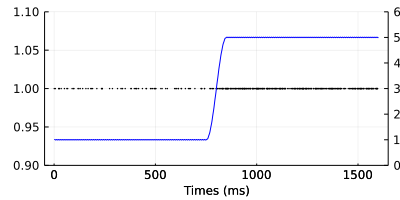

In [152]:
StopTime = 1.6
t = [0:dt:StopTime;]
spike_inds = Tuple.(findall(x -> x > 0, spikes)) # 行列内で0を超えてるスパイクのインデックスの要素を取得
spike_time = first.(spike_inds) # スパイク時系列
neuron_inds = last.(spike_inds) # 神経の番号(1~n_neurons)
plot(spike_time, neuron_inds ,st=:scatter,markersize=1,color="black",ylim=(0.9,1.1))
p1 = plot!(twinx(),res2, color="blue", ylim=(0,600))
plot(p1,
    xlabel = "Times (ms)", 
    layout = grid(1, 1, heights=[1]), guidefont=font(8), legend=false, size=(400,200))